In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

In [10]:
file_path = './data/all.jsonl'

# Charger le fichier JSONL dans un DataFrame
df = pd.read_json(file_path, nrows=5000, lines=True)

df.head()

,question,human_answers,chatgpt_answers,index,source
0,"Why is every book I hear about a "" NY Times # ...","[Basically there are many categories of "" Best...",[There are many different best seller lists th...,NaN,reddit_eli5
1,"If salt is so bad for cars , why do we use it ...",[salt is good for not dying in car crashes and...,[Salt is used on roads to help melt ice and sn...,NaN,reddit_eli5
2,Why do we still have SD TV channels when HD lo...,[The way it works is that old TV stations got ...,[There are a few reasons why we still have SD ...,NaN,reddit_eli5
3,Why has nobody assassinated Kim Jong - un He i...,[You ca n't just go around assassinating the l...,[It is generally not acceptable or ethical to ...,NaN,reddit_eli5
4,How was airplane technology able to advance so...,[Wanting to kill the shit out of Germans drive...,[After the Wright Brothers made the first powe...,NaN,reddit_eli5


In [11]:
df.shape

(5000, 5)

In [12]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   question         5000 non-null   object 
 1   human_answers    5000 non-null   object 
 2   chatgpt_answers  5000 non-null   object 
 3   index            2521 non-null   float64
 4   source           5000 non-null   object 
dtypes: float64(1), object(4)
memory usage: 195.4+ KB
None


## Preprocessing

In [13]:
df = df.drop(['source', 'index', 'question'], axis=1)
human_df = pd.DataFrame(df["human_answers"].explode("human_answers")).rename(columns={"human_answers": "answer"})
human_df["is_gpt"] = False

chatgpt_df = pd.DataFrame(df["chatgpt_answers"].explode("chatgpt_answers")).rename(columns={"chatgpt_answers": "answer"})
chatgpt_df["is_gpt"] = True

df = pd.concat([human_df, chatgpt_df], ignore_index=True)
df["answer"] = df["answer"].astype(str)

exclude = set(string.punctuation)
def remove_punctuation(row):
    row.answer = ''.join(ch for ch in row.answer if ch not in exclude)
    return row
    
df = df.apply(remove_punctuation, axis = 1)

df['answer'] = df['answer'].apply(lambda x: x.lower())


In [14]:
# we will lemmatize the words
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()
df['answer'] = df['answer'].apply(lambda x: " ".join([lemmatizer.lemmatize(word) for word in x.split()]))

[nltk_data] Downloading package wordnet to /home/onyxia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/onyxia/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [15]:
# we will also do a stemming of the words to see if it improves the model
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()
df['answer'] = df['answer'].apply(lambda x: " ".join([stemmer.stem(word) for word in x.split()]))

## Data analysis

In [16]:
df.shape

(20000, 2)

<Axes: xlabel='is_gpt', ylabel='count'>

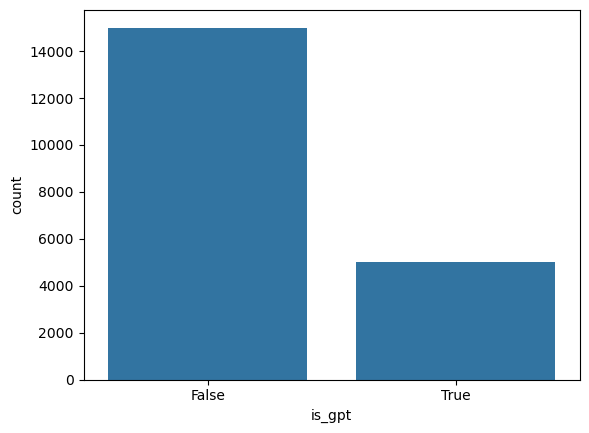

In [17]:
sns.countplot(x=df['is_gpt'])

In [18]:
description = pd.DataFrame()
description['description_length'] = df.answer.apply(len)
print("Mean description length: ", description['description_length'].mean())
print("Min overview length: ", description['description_length'].min())
print("Max overview length: ", description['description_length'].max())

Mean description length:  682.4956
Min overview length:  13
Max overview length:  10967


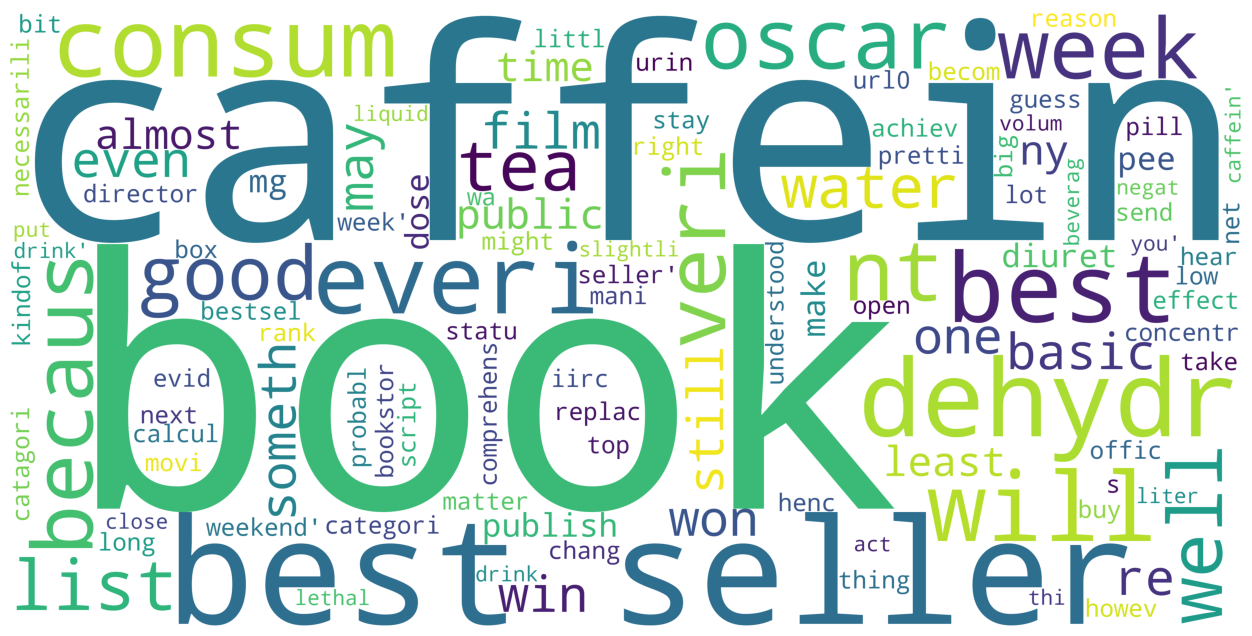

In [19]:
# word cloud sur les réponses humaines
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)
human = df[df['is_gpt'] == False]
action_text = human['answer'].values
wordcloud = WordCloud(stopwords=stopwords, background_color='white', height=2000, width=4000).generate(str(action_text))
plt.figure(figsize=(16,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

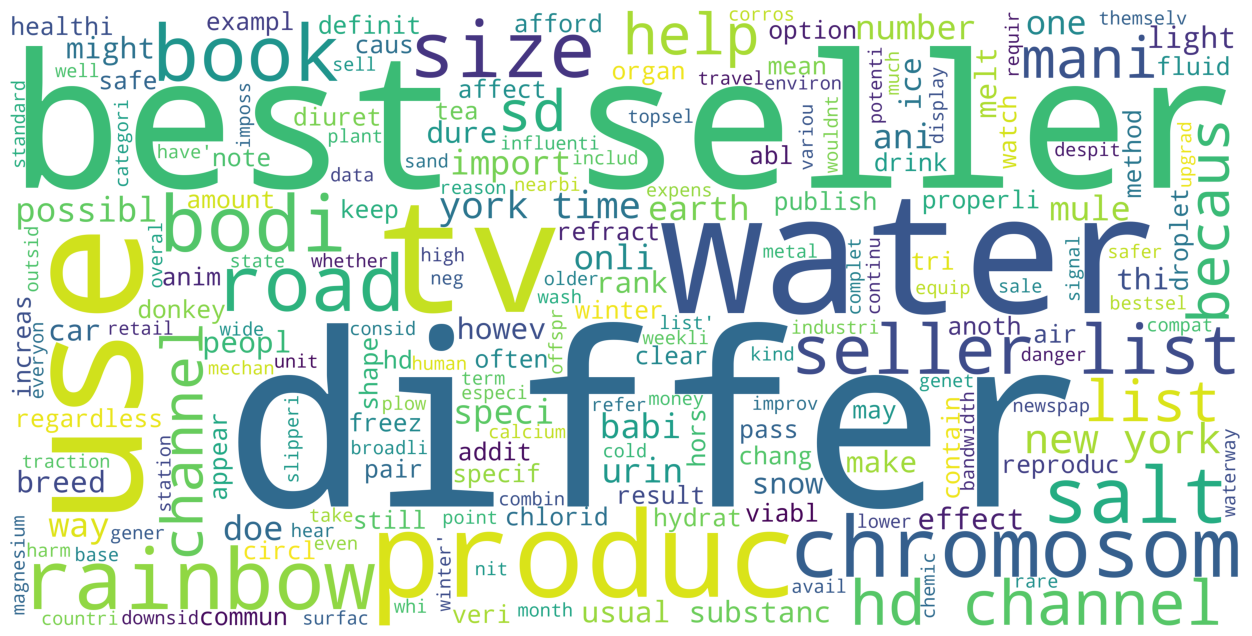

In [20]:
# word cloud sur les réponses de GPT
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)
human = df[df['is_gpt'] == True]
action_text = human['answer'].values
wordcloud = WordCloud(stopwords=stopwords, background_color='white', height=2000, width=4000).generate(str(action_text))
plt.figure(figsize=(16,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## Model selection and tunning 

In [21]:
X = df['answer']  
y = df['is_gpt']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

models = {
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {'model__n_estimators': [50, 100, 200]}
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(),
        'params': {'model__n_estimators': [50, 100, 200], 'model__learning_rate': [0.01, 0.1, 1.0]}
    },
    'SVM': {
        'model': SVC(),
        'params': {'model__C': [0.1, 1, 10], 'model__gamma': ['scale', 'auto']}
    },
    'Logistic Regression': {
        'model': LogisticRegression(),
        'params': {'model__C': [0.1, 1, 10]}
    },
    'Naive Bayes': {
        'model': MultinomialNB(),
        'params': {'model__alpha': [0.01, 0.1, 1]}
    }
}

grid_search_objects = {}
results = {}

for name, m in models.items():
    pipe = Pipeline([
        ('count_vect', CountVectorizer(stop_words='english', max_features=5000, ngram_range=(1, 2))),
        ('tfidf_transformer', TfidfTransformer()),
        ('model', m['model'])
    ])
    grid_search = GridSearchCV(pipe, m['params'], cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    grid_search_objects[name] = grid_search
    results[name] = {
        'best_score': grid_search.best_score_,
        'best_params': grid_search.best_params_
    }

for name, res in results.items():
    print(f"{name}: Meilleure précision = {res['best_score']}")
    print(f"Meilleurs paramètres : {res['best_params']}")


In [ ]:
import time
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report

# Évaluation des meilleurs modèles sur le test set avec des métriques supplémentaires
test_results = {}
for name, grid_search in grid_search_objects.items():
    best_model = grid_search.best_estimator_
    
    start_time = time.time()
    y_pred = best_model.predict(X_test)
    end_time = time.time()
    prediction_time = end_time - start_time
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    test_results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'prediction_time': prediction_time,
        'classification_report': classification_report(y_test, y_pred)
    }

    print(f"{name} Test Metrics:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"Prediction Time: {prediction_time} seconds")
    print(f"Classification Report:\n{classification_report(y_test, y_pred)}")


Random Forest Test Metrics:
Accuracy: 0.94825
Precision: 0.9492997373063353
Recall: 0.94825
F1 Score: 0.9466442621468368
Prediction Time: 0.5615620613098145 seconds
Classification Report:
              precision    recall  f1-score   support

       False       0.94      0.99      0.97      3023
        True       0.97      0.81      0.88       977

    accuracy                           0.95      4000
   macro avg       0.96      0.90      0.93      4000
weighted avg       0.95      0.95      0.95      4000

Gradient Boosting Test Metrics:
Accuracy: 0.952
Precision: 0.9515480041605087
Recall: 0.952
F1 Score: 0.9514201792528174
Prediction Time: 0.44130444526672363 seconds
Classification Report:
              precision    recall  f1-score   support

       False       0.96      0.98      0.97      3023
        True       0.93      0.87      0.90       977

    accuracy                           0.95      4000
   macro avg       0.94      0.92      0.93      4000
weighted avg       0.95 